### Case 1: For Amplitude (A) = 1.5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
from tcn import TCN, tcn_full_summary
from tqdm import tqdm
import time

from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,r2_score
from keras.losses import Huber
import keras.backend as K

from utilis import QuCal, pre_processing, plot_losses
from model import TCN_autoencoder

2025-02-04 16:38:04.962453: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 16:38:05.101702: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
Y = np.load('../dataset/Data_Y.npy', allow_pickle=True)
Y.shape

(3700, 512, 1)

lowest frequency for the data:  4.260000000000001
number of frewuencies: 3700


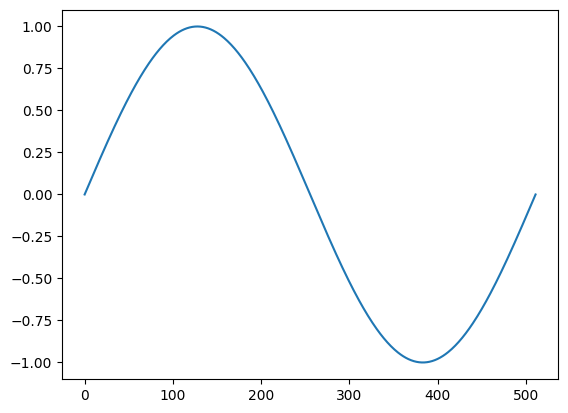

In [3]:
full_ω, t, E = QuCal()

100%|███████████████████████████████████| 3700/3700 [00:00<00:00, 104134.29it/s]

omega values for input data:  (3700,)
x data : (3700, 512)


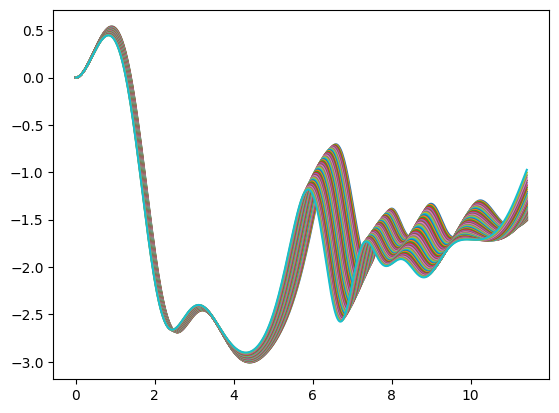

scaled_X_train:  (2960, 512, 1)
scaled_y_train:  (2960, 512, 1)
scaled_X_test:  (740, 512, 1)
scaled_y_test:  (740, 512, 1)
scaled_X_train max:  1.0
scaled_X_train min:  3.6617265e-11
scaled_y_train max:  0.99998325
scaled_y_train min :  0.0002274017


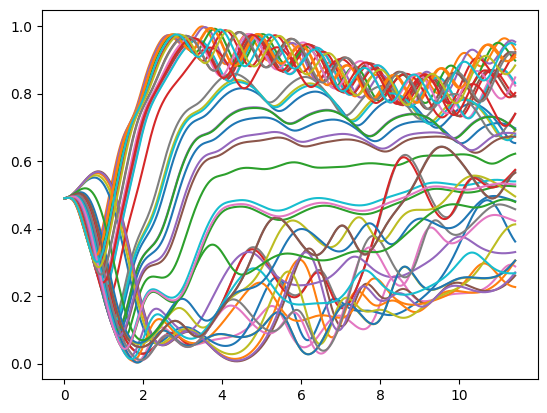

In [4]:
scaled_X_train, scaled_y_train,scaled_X_test,scaled_y_test, omega_y_test = pre_processing(Y , full_ω,t, F0 = 1.5 )

In [5]:

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

with mirrored_strategy.scope():
    

    TCN_AE = TCN_autoencoder(input_size=512,f1 = 5,f2 = 5, lf = 4,latent_space_tcn = True,last_2_layer_dense = False)
    #Compile the model
    TCN_AE.compile(optimizer=Adam(learning_rate = 0.001), loss=Huber(delta=1.0))



#Define a callback to save the best model
checkpoint_filepath = 'outputs/best_1d_tcn_model_v10_bkp.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

#Display the model architecture
TCN_AE.summary()

2025-02-04 16:38:18.304205: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 16:38:18.785419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46614 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1d:00.0, compute capability: 8.6
2025-02-04 16:38:18.786123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46614 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:1e:00.0, compute capability: 8.6
2025-02-04 16:38:18.786685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 1)]          0         
                                                                 
 tcn (TCN)                   (None, 512, 5)            430       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 256, 5)           0         
 )                                                               
                                                                 
 tcn_1 (TCN)                 (None, 256, 5)            480       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 128, 5)           0         
 1D)                                                             
                                                                 
 tcn_2 (TCN)                 (None, 128, 4)            348   

Epoch 1/50


2025-02-04 16:38:28.712248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2025-02-04 16:38:29.399155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


24/24 [==============================] - ETA: 0s - loss: 1.2789
Epoch 1: val_loss improved from inf to 0.14087, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
24/24 [==============================] - 12s 154ms/step - loss: 1.2789 - val_loss: 0.1409
Epoch 2/50
23/24 [===========================>..] - ETA: 0s - loss: 0.1273
Epoch 2: val_loss improved from 0.14087 to 0.09732, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
24/24 [==============================] - 1s 50ms/step - loss: 0.1271 - val_loss: 0.0973
Epoch 3/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0786
Epoch 3: val_loss improved from 0.09732 to 0.05392, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
24/24 [==============================] - 1s 50ms/step - loss: 0.0785 - val_loss: 0.0539
Epoch 4/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0495
Epoch 4: val_loss improved from 0.05392 to 0.04013, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
24/24 [======================

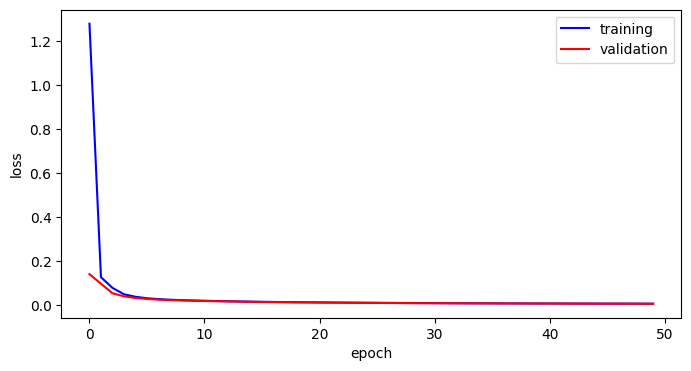

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 0.0064
Epoch 1: val_loss improved from 0.00646 to 0.00629, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
47/47 [==============================] - 2s 47ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 0.0062
Epoch 2: val_loss improved from 0.00629 to 0.00611, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
47/47 [==============================] - 2s 44ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 0.0060
Epoch 3: val_loss improved from 0.00611 to 0.00594, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
47/47 [==============================] - 2s 43ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 4/50
47/47 [==============================] - ETA: 0s - loss: 0.0059
Epoch 4: val_loss improved from 0.00594 to 0.00578, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
47/47 [=========

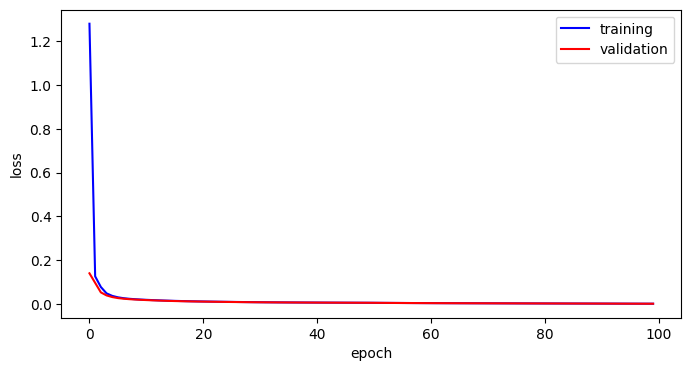

Epoch 1/50
93/93 [==============================] - ETA: 0s - loss: 0.0022
Epoch 1: val_loss improved from 0.00220 to 0.00217, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
93/93 [==============================] - 4s 42ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2/50
93/93 [==============================] - ETA: 0s - loss: 0.0021
Epoch 2: val_loss improved from 0.00217 to 0.00200, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
93/93 [==============================] - 4s 41ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 3/50
93/93 [==============================] - ETA: 0s - loss: 0.0020
Epoch 3: val_loss improved from 0.00200 to 0.00194, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
93/93 [==============================] - 4s 41ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/50
93/93 [==============================] - ETA: 0s - loss: 0.0020
Epoch 4: val_loss improved from 0.00194 to 0.00190, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
93/93 [=========

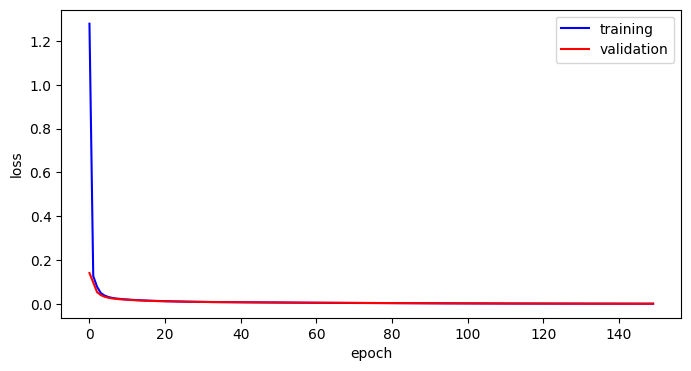

Epoch 1/50
185/185 [==============================] - ETA: 0s - loss: 8.9138e-04
Epoch 1: val_loss did not improve from 0.00079
185/185 [==============================] - 7s 39ms/step - loss: 8.9138e-04 - val_loss: 8.2042e-04
Epoch 2/50
185/185 [==============================] - ETA: 0s - loss: 7.8568e-04
Epoch 2: val_loss did not improve from 0.00079
185/185 [==============================] - 7s 39ms/step - loss: 7.8568e-04 - val_loss: 8.3806e-04
Epoch 3/50
185/185 [==============================] - ETA: 0s - loss: 7.4462e-04
Epoch 3: val_loss improved from 0.00079 to 0.00069, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
185/185 [==============================] - 7s 40ms/step - loss: 7.4462e-04 - val_loss: 6.9266e-04
Epoch 4/50
185/185 [==============================] - ETA: 0s - loss: 7.2867e-04
Epoch 4: val_loss did not improve from 0.00069
185/185 [==============================] - 7s 39ms/step - loss: 7.2867e-04 - val_loss: 6.9863e-04
Epoch 5/50
185/185 [==================

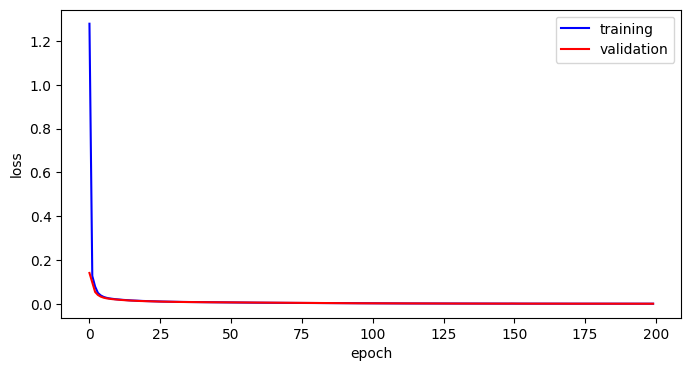

Epoch 1/50
369/370 [============================>.] - ETA: 0s - loss: 5.0056e-04
Epoch 1: val_loss did not improve from 0.00033
370/370 [==============================] - 15s 39ms/step - loss: 5.0033e-04 - val_loss: 3.4416e-04
Epoch 2/50
370/370 [==============================] - ETA: 0s - loss: 4.1497e-04
Epoch 2: val_loss did not improve from 0.00033
370/370 [==============================] - 14s 39ms/step - loss: 4.1497e-04 - val_loss: 3.7844e-04
Epoch 3/50
369/370 [============================>.] - ETA: 0s - loss: 3.9766e-04
Epoch 3: val_loss improved from 0.00033 to 0.00033, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
370/370 [==============================] - 15s 39ms/step - loss: 3.9728e-04 - val_loss: 3.2593e-04
Epoch 4/50
369/370 [============================>.] - ETA: 0s - loss: 3.5852e-04
Epoch 4: val_loss did not improve from 0.00033
370/370 [==============================] - 14s 38ms/step - loss: 3.5864e-04 - val_loss: 3.5864e-04
Epoch 5/50
370/370 [==============

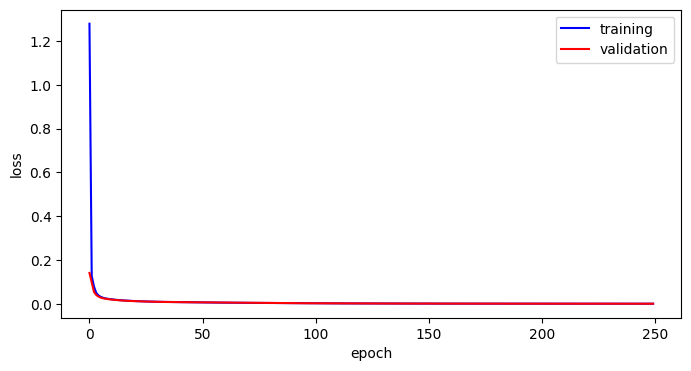

Execution time 1445.8513 seconds


In [6]:
# ##### Train the model
tic = time.perf_counter()
for n in ([7,6,5,4,3]):  
    # training in a cycle with increasing batch size  . IF i increase the size to 10 from 7 then the train process just stops after 5th cycle and this is because of the GPU memory issue.

    batch_size = 2**n  
    
    history = TCN_AE.fit(scaled_X_train, scaled_y_train,
        epochs=50,
        batch_size=batch_size,
        validation_data=(scaled_X_test, scaled_y_test),callbacks=[model_checkpoint_callback])
    
    loss_save = history.history['loss']
    val_loss_save = history.history['val_loss']
    if n in ([6,5,4,3]):
        
        loss_sum = np.concatenate((loss_sum, loss_save), axis = 0)
        val_loss_sum = np.concatenate((val_loss_sum, val_loss_save), axis = 0)
    else:
   
        loss_sum = loss_save
        val_loss_sum = val_loss_save  

    plot_losses(loss_sum,val_loss_sum)

toc = time.perf_counter()
print(f"Execution time {toc - tic:0.4f} seconds")



24/24 [==============================] - 2s 12ms/step
(740, 512, 1)


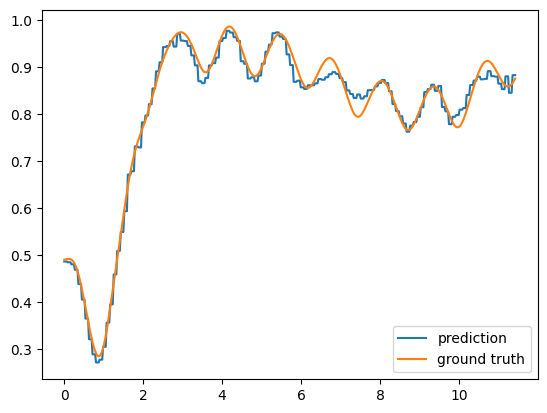

In [7]:
#Compute predicted values
prediction_test = TCN_AE.predict(scaled_X_test)
print(prediction_test.shape)


# # Create a StandardScaler object


plt.plot(t,prediction_test[50],label = 'prediction')
plt.plot(t,scaled_y_test[50], label = 'ground truth')
plt.legend()
plt.show()

In [8]:
r2_test = r2_score(scaled_y_test.reshape(-1), prediction_test.reshape(-1))
print(r2_test)

r2_test_set = [r2_score(scaled_y_test[i].reshape(-1), prediction_test[i].reshape(-1)) for i in range(len(scaled_y_test))]
print(len(r2_test_set))

0.9963994709010436
740


In [9]:

above = np.sum(np.array(r2_test_set) > 0.90)/740 * 100
print('$R^{2}$ above 90 :',above)

above1 = np.sum(np.array(r2_test_set) > 0.95)/740 * 100
print('$R^{2}$ above 95 :',above1)

$R^{2}$ above 90 : 100.0
$R^{2}$ above 95 : 99.45945945945947


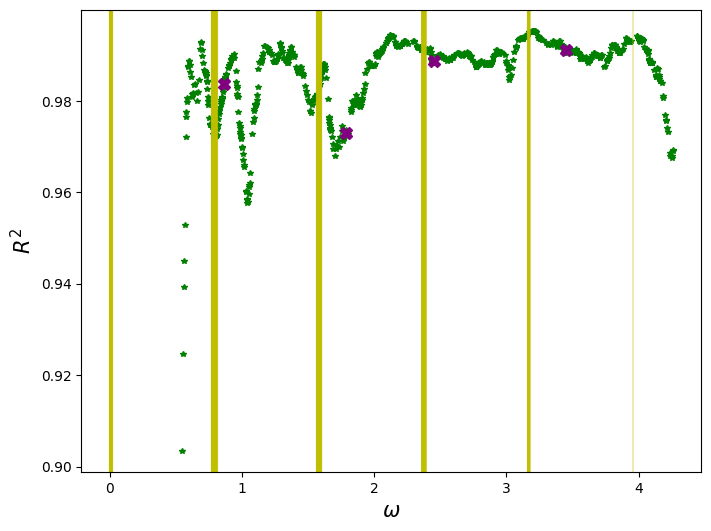

In [10]:
plt.figure(figsize=(8, 6))  # Adjust the width and height as needed


plt.plot(omega_y_test, r2_test_set, '*', markersize=4, color='g')
# plt.plot(ω_test, r2_test_set, '.', color='red')
# Plot highlighted points in red

for i in [2, 100, 250, 600]:
    plt.plot(omega_y_test[i], r2_test_set[i], 'X',markersize=9, color='purple')


for _ in np.unique(np.round(np.abs(E[:, np.newaxis] - E), 4)):
    plt.axvline(_, c='y', alpha=0.3)
# plt.axhline(r2_test, color='blue', linestyle='--')  # Plot the horizontal line for r2_test
# plt.text(0.14, r2_test, f"Avg. $R^{2}$ = {r2_test:.4}", color='blue',fontsize=12,weight='bold', va='bottom', ha='left')  # Display the value of r2_test on the plot
plt.xlabel(r"$\omega$",fontsize=15)
plt.ylabel(r"$R^2$",fontsize=15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
# plt.title("$\omega$ vs. $R^2$ score")
#plt.title("Amplitude = 1", fontsize = 14)
# plt.savefig('R2_Omega_v4_1.png')
plt.savefig('outputs/A1.pdf', dpi=1000, bbox_inches='tight')
plt.show()

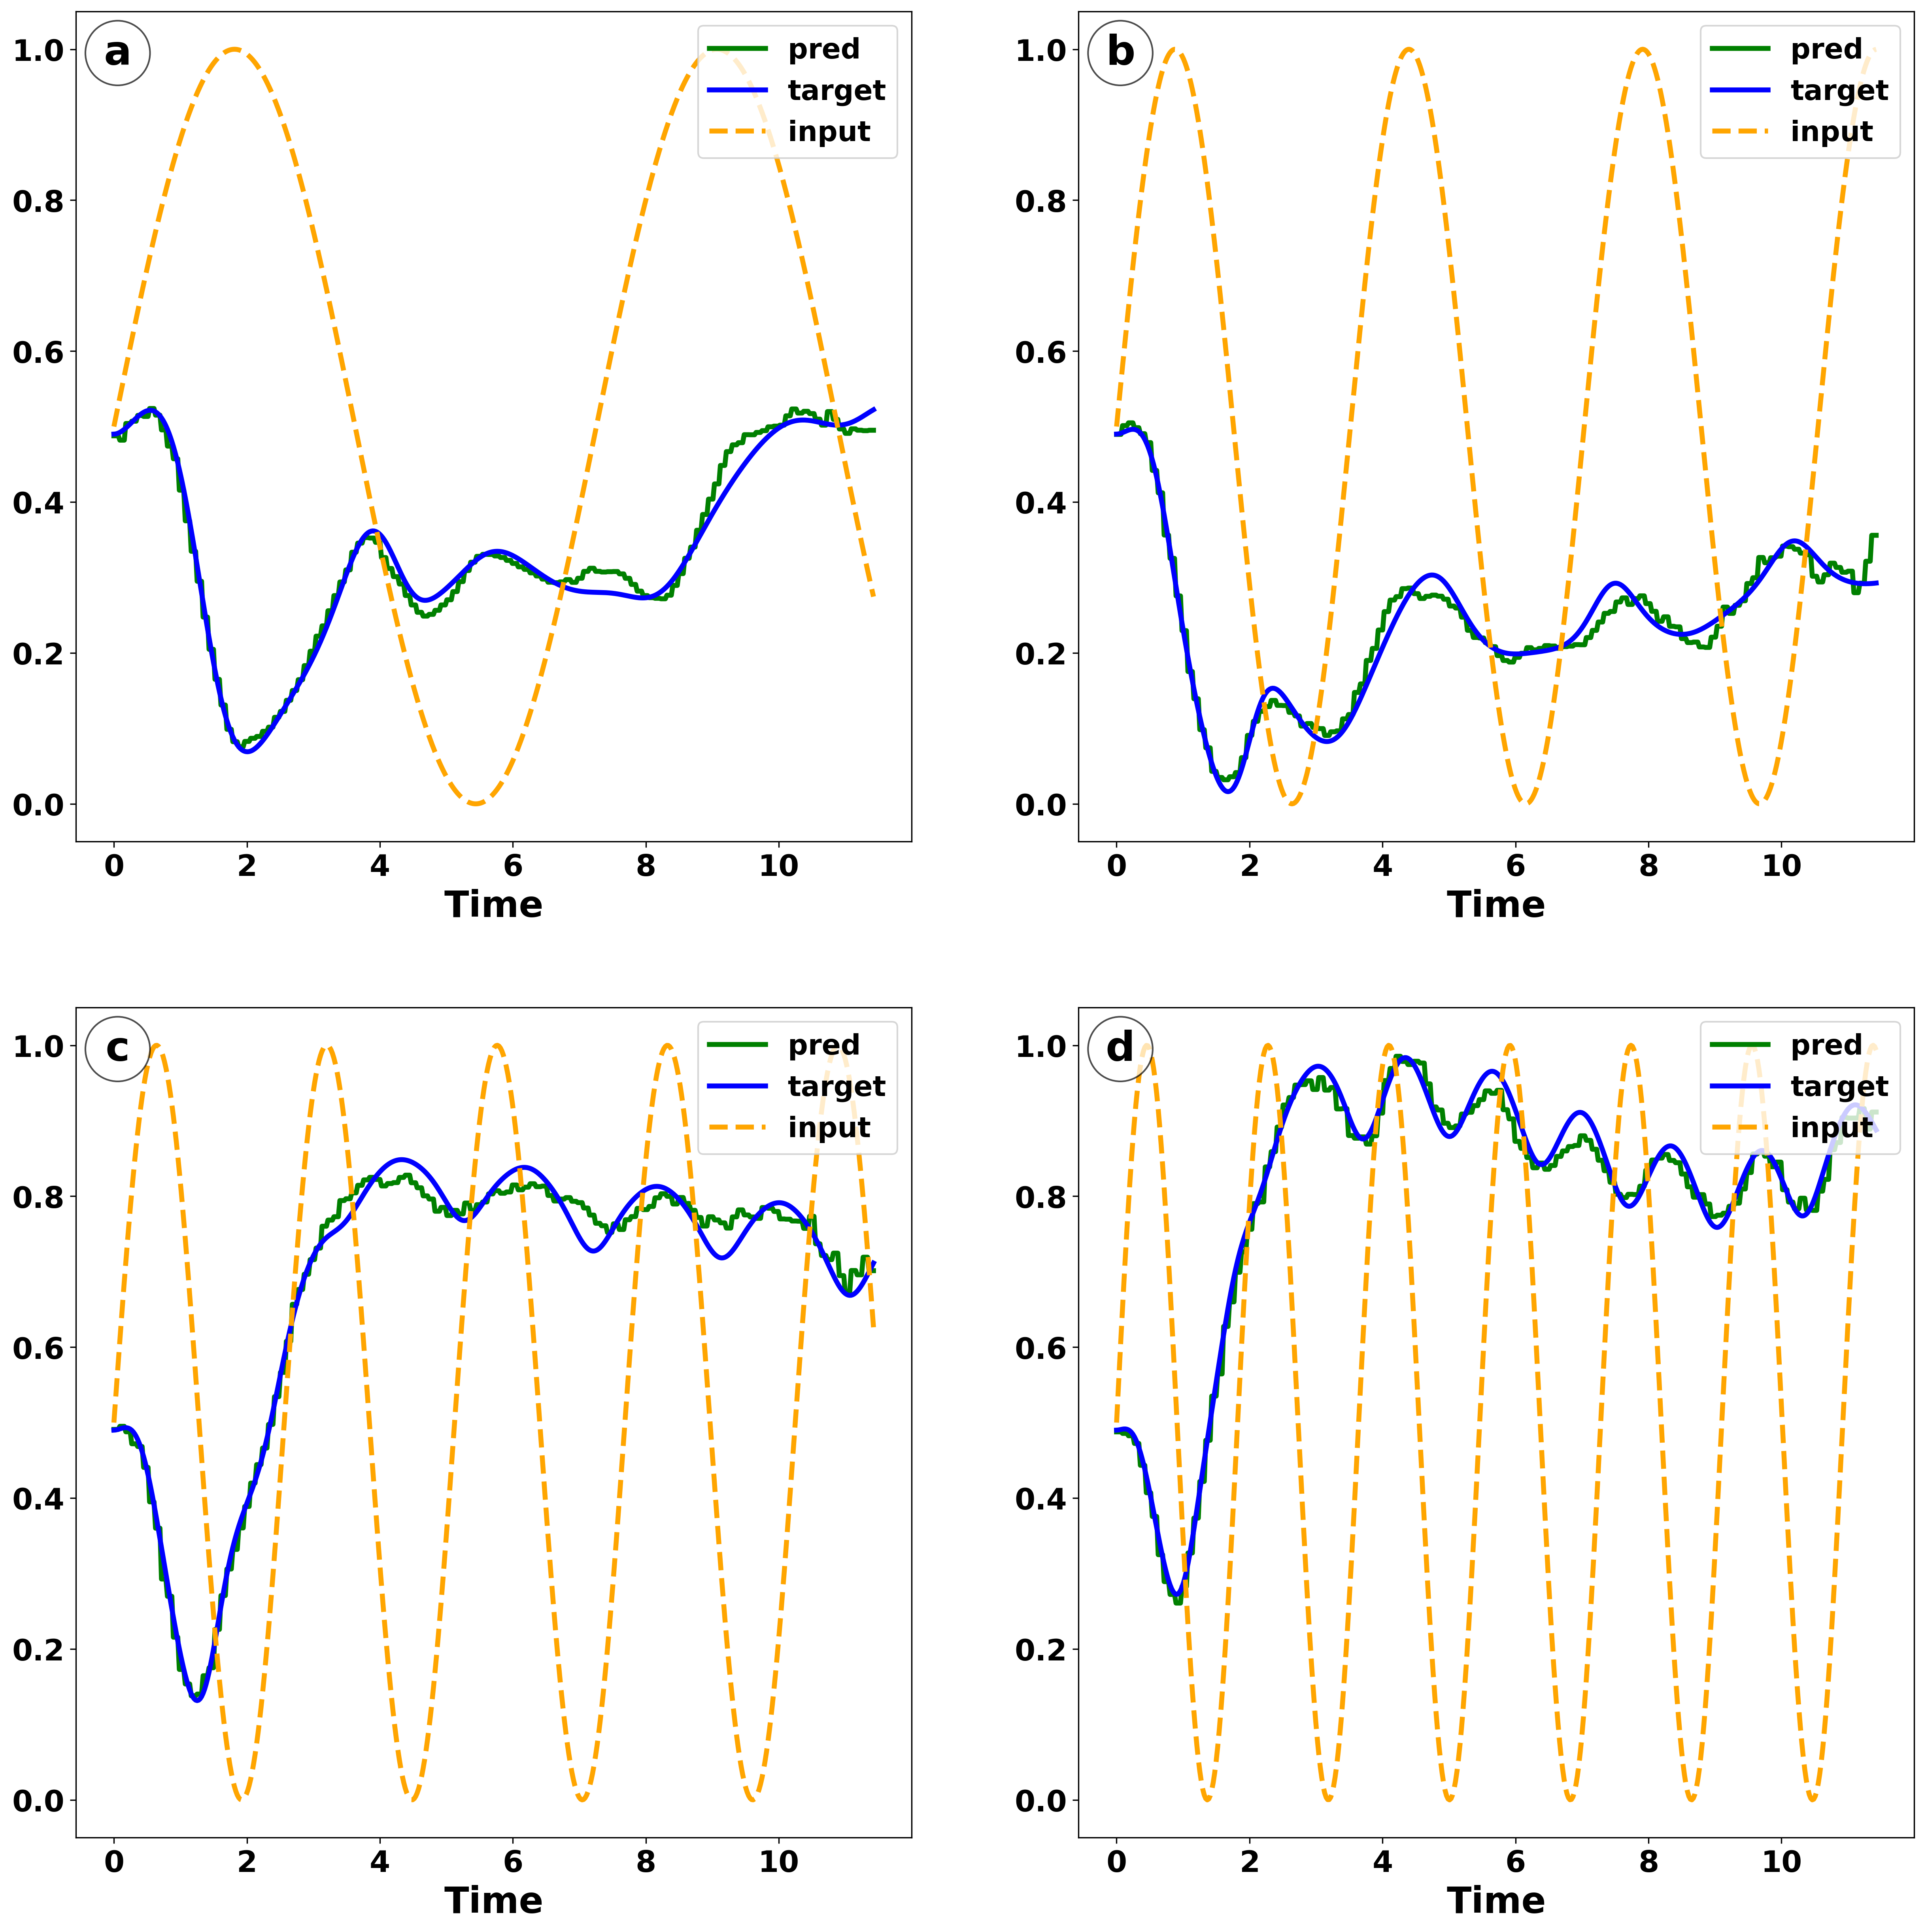

In [11]:

from matplotlib import rcParams

rcParams['font.weight'] = 'bold'
rcParams['font.size'] = 17
labels = ['a', 'b', 'c', 'd']

plt.figure(figsize=(20, 20), dpi=300)
arr =  np.array([2, 100, 250, 600])
j=0
for i in arr:
    plt.subplot(2, 2, j+1)
    plt.plot(t,prediction_test[i, :], label = "pred",color = 'green', linewidth=3)
    plt.plot(t, scaled_y_test[ i, :], label = "target", color = 'blue', linewidth=3  )
    plt.plot( t, scaled_X_test[i, :],'--', label = "input", color = 'orange', linewidth=3 )
    #plt.plot( t, F0 * np.sin(ω_train[i] * t),'--', label = "input",linewidth=4 )
    plt.legend(loc='upper right')
    #plt.title("ω = {}".format(omega_y_test[i]),fontsize=22)
    plt.xlabel("Time",fontsize=22)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
#     plt.ylabel("Expectation Value of Magnetization",  fontsize=27)
    plt.annotate(labels[j], xy=(0.05, 0.95), xycoords='axes fraction', fontsize=25,
                 ha='center', va='center',
                 bbox=dict(boxstyle='circle', fc='w', ec='k', lw=1, alpha=0.7))
    j=j+1

plt.savefig('outputs/chaotic1_5TEST.pdf', dpi=700, bbox_inches='tight')
plt.show()
